In [49]:
# %% Imports
import os, math, json
import torch, torchaudio
import matplotlib.pyplot as plt
from torchaudio.transforms import Resample, Spectrogram, MelSpectrogram, MFCC
from torchaudio.functional import vad
from IPython.display import Audio, display
print('torch', torch.__version__, 'torchaudio', torchaudio.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

torch 2.8.0+cu128 torchaudio 2.8.0+cu128


device(type='cuda')

In [50]:
# %% Config
AUDIO_PATHS = [
    'audio_dataset/test-123-week4.wav'
]
REFERENCE_TEXTS = [
    'one two three'
]
SAMPLE_RATE_TARGET = 16000
APPLY_VAD = False
NORMALIZE = True  # rms 정규화


In [51]:
# %% Utilities
def load_audio(path, target_sr=16000, apply_vad=True, normalize=True):
    wav, sr = torchaudio.load(path)
    # mono
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    # resample
    if sr != target_sr:
        wav = Resample(sr, target_sr)(wav)
        sr = target_sr
    # VAD (frame_length=30ms, local energy threshold)
    if apply_vad:
        frame_len = int(sr * 0.03)
        hop_len = int(sr * 0.01)
        voiced = []
        i = 0
        while i + frame_len <= wav.shape[-1]:
            frame = wav[:, i:i+frame_len]
            try:
                keep = vad(frame, sample_rate=sr)
                if keep.numel() > 0:
                    voiced.append(frame)
            except Exception:
                voiced.append(frame)
            i += hop_len
        if voiced:
            wav = torch.cat(voiced, dim=-1)
    # normalize (RMS)
    if normalize:
        rms = wav.pow(2).mean().sqrt().clamp(min=1e-8)
        wav = wav / rms
    return wav, sr

def plot_feature(tensor, title, sr, hop=None):
    plt.figure(figsize=(10,3))
    if tensor.dim() == 2:
        plt.imshow(tensor.log2().clamp(min=-10).cpu(), aspect='auto', origin='lower')
    else:
        plt.plot(tensor.squeeze().cpu())
    plt.title(f"{title} (sr={sr})")
    plt.xlabel('Time')
    plt.colorbar()
    plt.show()


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


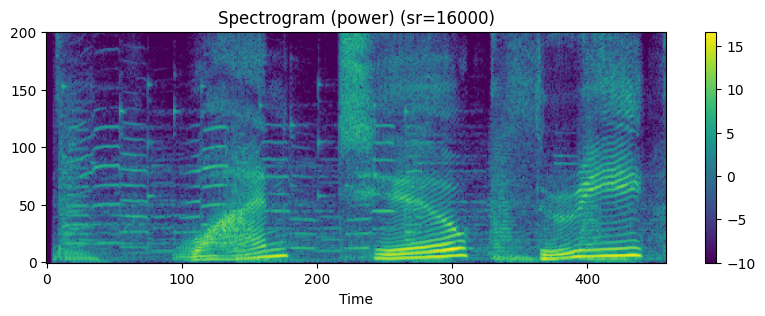

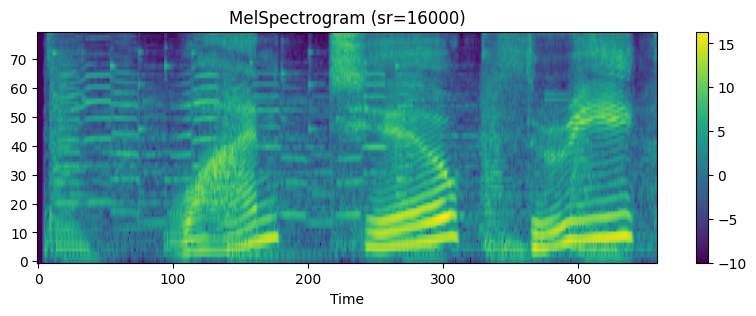

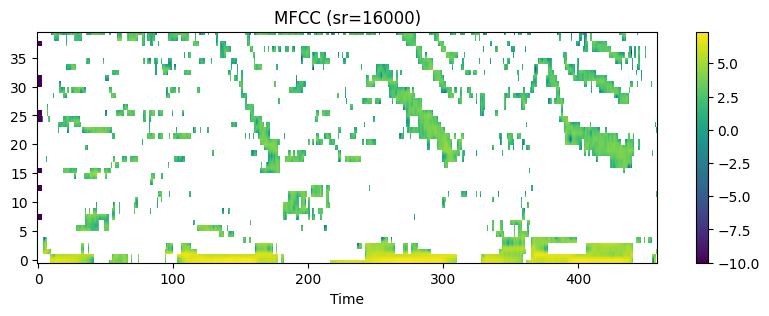

In [52]:
# %% Feature Extraction demo
if AUDIO_PATHS:
    wav, sr = load_audio(AUDIO_PATHS[0], SAMPLE_RATE_TARGET, APPLY_VAD, NORMALIZE)
    display(Audio(wav.squeeze().cpu().numpy(), rate=sr))
    spec = Spectrogram(n_fft=400, win_length=400, hop_length=160, power=2.0)(wav)
    mel = MelSpectrogram(sr, n_fft=400, win_length=400, hop_length=160, n_mels=80)(wav)
    mfcc = MFCC(sr, n_mfcc=40, melkwargs={'n_fft':400, 'hop_length':160, 'n_mels':80})(wav)
    plot_feature(spec.squeeze(0), 'Spectrogram (power)', sr)
    plot_feature(mel.squeeze(0), 'MelSpectrogram', sr)
    plot_feature(mfcc.squeeze(0), 'MFCC', sr)
else:
    print('AUDIO_PATHS가 비어있습니다. 위 셀에서 경로를 채워 넣으세요.')


In [53]:
# %% ASR inference helpers
from torchaudio.pipelines import (
    WAV2VEC2_ASR_BASE_960H,
    WAV2VEC2_ASR_LARGE_960H,
    WAV2VEC2_ASR_LARGE_LV60K_960H,
    EMFORMER_RNNT_BASE_LIBRISPEECH,
)
import re

def greedy_decode(emissions, labels):
    # CTC greedy
    indices = torch.argmax(emissions, dim=-1)
    tokens = []
    prev = None
    for i in indices:
        if i != 0 and i != prev:
            tokens.append(labels[i])
        prev = i
    return ''.join(tokens)

def text_normalize(s):
    return re.sub(r"[^A-Z ']+", '', s.upper()).strip()

def wer(ref, hyp):
    r = ref.split()
    h = hyp.split()
    dp = [[0]*(len(h)+1) for _ in range(len(r)+1)]
    for i in range(len(r)+1): dp[i][0] = i
    for j in range(len(h)+1): dp[0][j] = j
    for i in range(1,len(r)+1):
        for j in range(1,len(h)+1):
            cost = 0 if r[i-1]==h[j-1] else 1
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
    return dp[-1][-1]/max(1,len(r))

def run_pipeline(bundle, wav, sr):
    model = bundle.get_model().to(device)
    model.eval()
    with torch.inference_mode():
        if hasattr(bundle, 'sample_rate') and bundle.sample_rate != sr:
            wav = Resample(sr, bundle.sample_rate)(wav)
            sr = bundle.sample_rate
        emissions, _ = model(wav.to(device))
        emissions = torch.log_softmax(emissions, dim=-1)[0].cpu()
    tokens = bundle.get_labels()
    hyp = greedy_decode(emissions, tokens)
    return hyp, sr


In [54]:
def bundle_label(bundle):
    # torchaudio 번들 객체에서 보기 좋은 이름 뽑기
    for attr in ("name", "_name"):
        if hasattr(bundle, attr):
            val = getattr(bundle, attr)
            if isinstance(val, str) and val:
                return val
    # fallback: 클래스명
    return type(bundle).__name__

In [55]:
# %% Try multiple models and compute WER if reference available
BUNDLES = [
    WAV2VEC2_ASR_BASE_960H,
    WAV2VEC2_ASR_LARGE_960H,
    WAV2VEC2_ASR_LARGE_LV60K_960H,
    EMFORMER_RNNT_BASE_LIBRISPEECH,
]

results = []
if AUDIO_PATHS:
    for idx, path in enumerate(AUDIO_PATHS):
        print(f"\n=== File #{idx+1}: {path}")
        wav, sr = load_audio(path, SAMPLE_RATE_TARGET, APPLY_VAD, NORMALIZE)

        ref = None
        if idx < len(REFERENCE_TEXTS) and REFERENCE_TEXTS[idx]:
            ref = text_normalize(REFERENCE_TEXTS[idx])

        display(Audio(wav.squeeze().cpu().numpy(), rate=sr))
        best = None  # (wer, label, hyp)

        for bundle in BUNDLES:
            label = bundle_label(bundle)
            try:
                hyp, used_sr = run_pipeline(bundle, wav.clone(), sr)
                hyp_n = text_normalize(hyp)
                w = wer(ref, hyp_n) if ref else None
                w_str = f"{w:.3f}" if isinstance(w, (int, float)) else "N/A"
                print(f"- {label}: {hyp_n}  WER={w_str}")

                cand = {'file': path, 'model': label, 'hyp': hyp_n, 'wer': w}
                results.append(cand)

                if ref is not None:
                    if best is None or (w is not None and w < best[0]):
                        best = (w, label, hyp_n)
            except Exception as e:
                print(f"  [skip {label}] {e}")

        if best:
            print(f"BEST for {path}: {best[1]} (WER={best[0]:.3f})\n{best[2]}")
else:
    print('AUDIO_PATHS가 비어있습니다. 위 셀에서 경로를 채워 넣으세요.')



=== File #1: audio_dataset/test-123-week4.wav


- Wav2Vec2ASRBundle: ONETWOTHREE  WER=1.000
- Wav2Vec2ASRBundle: WINETETHREE  WER=1.000
- Wav2Vec2ASRBundle: ONETILTHREE  WER=1.000
  [skip RNNTBundle] 'RNNTBundle' object has no attribute 'get_model'
BEST for audio_dataset/test-123-week4.wav: Wav2Vec2ASRBundle (WER=1.000)
ONETWOTHREE


In [ ]:
# === Raw loader: 전처리 없이 '그대로' 읽기 (재생만 16k로 맞춤) ===
def load_audio_raw(path):
    import torchaudio
    from torchaudio.transforms import Resample

    # 백엔드 순차 시도 (m4a/mp3 호환성)
    wav = sr = None
    for backend in ("torchcodec", "sox_io", None):
        try:
            kwargs = {}
            if backend is not None:
                kwargs["backend"] = backend
            wav, sr = torchaudio.load(path, **kwargs)
            break
        except Exception:
            pass
    if wav is None:
        import librosa, numpy as np, torch
        y, sr = librosa.load(path, sr=None, mono=False)
        if y.ndim == 1:
            y = np.expand_dims(y, 0)
        wav = torch.from_numpy(y)

    return wav, sr

# === A/B 재생 & 기본 메타 비교 ===
from IPython.display import Audio, display
from torchaudio.transforms import Resample
import torch

print(f"\n=== File #{idx+1}: {path}")
raw_wav, raw_sr = load_audio_raw(path)  # 원본
proc_wav, proc_sr = load_audio(path, SAMPLE_RATE_TARGET, APPLY_VAD, NORMALIZE)  # 전처리본

# 재생은 둘 다 16kHz로 맞춰서 비교
def to16k(wav, sr):
    if sr != 16000:
        wav = Resample(sr, 16000)(wav); sr = 16000
    # 모노로 들어보고 싶으면 주석 해제
    # if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
    return wav, sr

rw, rs = to16k(raw_wav.clone(), raw_sr)
pw, ps = to16k(proc_wav.clone(), proc_sr)

print("[Raw]   dur(sec)=", rw.shape[-1]/rs, " RMS=", float(rw.pow(2).mean().sqrt()))
display(Audio(rw.squeeze().cpu().numpy(), rate=rs))

print("[Proc]  dur(sec)=", pw.shape[-1]/ps, " RMS=", float(pw.pow(2).mean().sqrt()))
display(Audio(pw.squeeze().cpu().numpy(), rate=ps))

# 이후 ASR 입력은 proc_wav / proc_sr 사용 (현행과 동일)
wav, sr = proc_wav, proc_sr



=== File #1: audio_dataset/test-123-week4.wav
[Raw]   dur(sec)= 4.5866875  RMS= 0.0552661269903183


[Proc]  dur(sec)= 4.5866875  RMS= 0.9999999403953552


RMS raw=0.055266  proc=1.000000  diff=0.944734
SNR(proc vs diff) = 0.49 dB


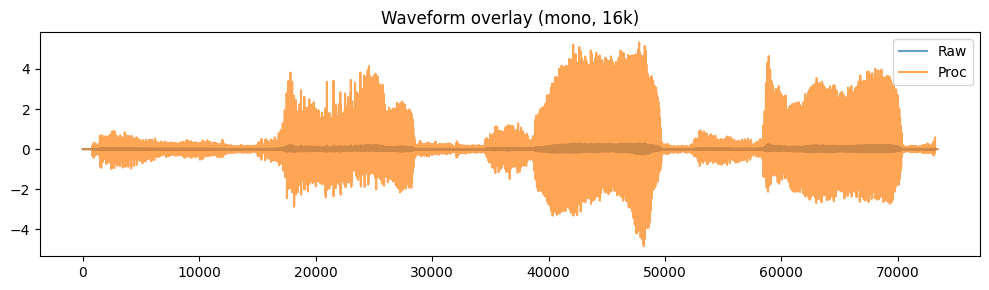

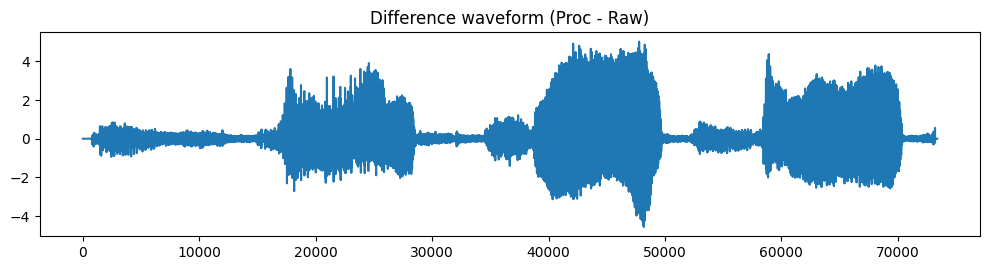

In [57]:
import torch, matplotlib.pyplot as plt
from torchaudio.transforms import Resample

def to_mono_16k(wav, sr):
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != 16000:
        wav = Resample(sr, 16000)(wav); sr = 16000
    return wav, sr

# 원본/전처리 불러온 객체 사용
raw_wav, raw_sr = load_audio_raw(AUDIO_PATHS[0])    # 앞에서 만든 raw 로더
proc_wav, proc_sr = load_audio(AUDIO_PATHS[0], SAMPLE_RATE_TARGET, APPLY_VAD, NORMALIZE)

rw, rs = to_mono_16k(raw_wav.clone(), raw_sr)
pw, ps = to_mono_16k(proc_wav.clone(), proc_sr)

# 길이를 맞춰 비교
L = min(rw.shape[-1], pw.shape[-1])
rw = rw[:, :L]; pw = pw[:, :L]
diff = pw - rw

def rms(x): return float(x.pow(2).mean().sqrt())

print(f"RMS raw={rms(rw):.6f}  proc={rms(pw):.6f}  diff={rms(diff):.6f}")

# SNR (proc 기준) — 값이 클수록 전처리가 raw 대비 많이 달라졌음을 의미
snr_db = 20 * torch.log10((pw.pow(2).mean().sqrt() / (diff.pow(2).mean().sqrt()+1e-12))).item()
print(f"SNR(proc vs diff) = {snr_db:.2f} dB")

# 파형 오버레이
plt.figure(figsize=(10,3))
plt.plot(rw.squeeze().cpu(), alpha=0.7, label='Raw')
plt.plot(pw.squeeze().cpu(), alpha=0.7, label='Proc')
plt.title('Waveform overlay (mono, 16k)')
plt.legend(); plt.tight_layout(); plt.show()

# 차이파형
plt.figure(figsize=(10,2.8))
plt.plot(diff.squeeze().cpu())
plt.title('Difference waveform (Proc - Raw)')
plt.tight_layout(); plt.show()


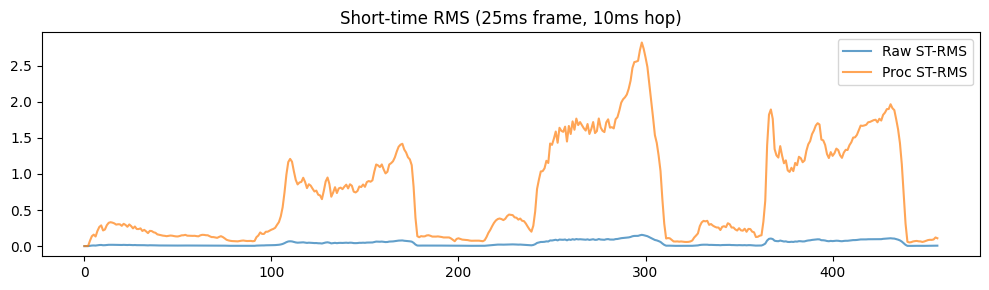

In [58]:
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

def frame_rms(x, frame=400, hop=160):  # 25ms/10ms @16k
    x = x.squeeze()
    frames = x.unfold(0, frame, hop)  # [num_frames, frame]
    rms = frames.pow(2).mean(dim=1).sqrt()
    return rms

r_raw = frame_rms(rw, frame=400, hop=160)
r_proc = frame_rms(pw, frame=400, hop=160)

plt.figure(figsize=(10,3))
plt.plot(r_raw.cpu(), label='Raw ST-RMS', alpha=0.7)
plt.plot(r_proc.cpu(), label='Proc ST-RMS', alpha=0.7)
plt.title('Short-time RMS (25ms frame, 10ms hop)')
plt.legend(); plt.tight_layout(); plt.show()


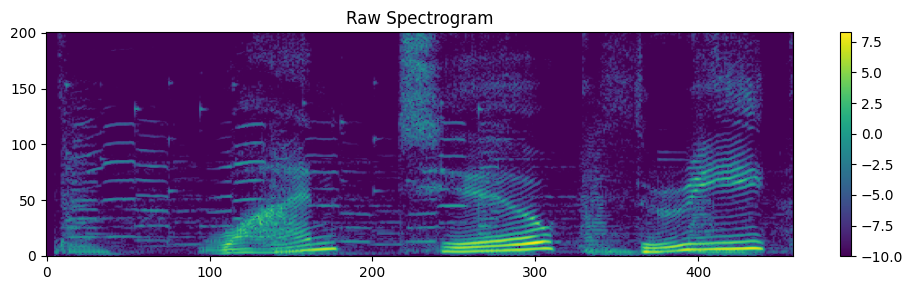

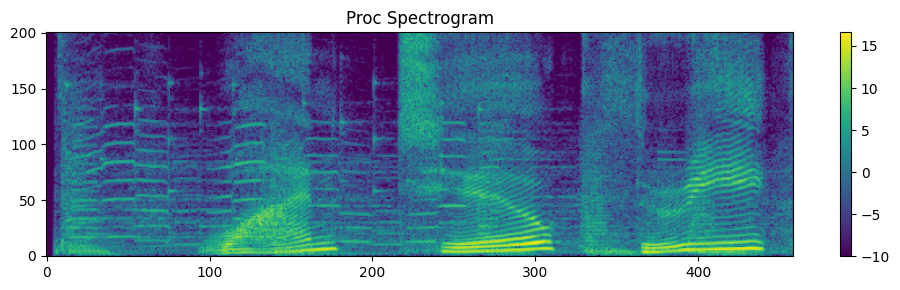

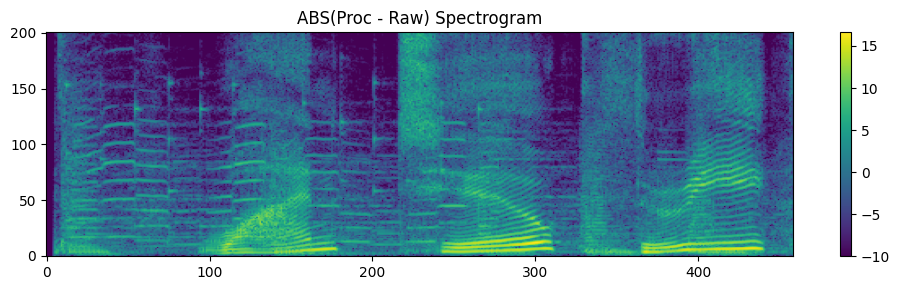

In [59]:
from torchaudio.transforms import Spectrogram

spec_tf = Spectrogram(n_fft=400, win_length=400, hop_length=160, power=2.0)
S_raw = spec_tf(rw)
S_proc = spec_tf(pw)
S_diff = (S_proc - S_raw).abs()

def show_spec(S, title):
    plt.figure(figsize=(10,3))
    plt.imshow(S.squeeze().log2().clamp(min=-10).cpu(), aspect='auto', origin='lower')
    plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()

show_spec(S_raw, 'Raw Spectrogram')
show_spec(S_proc, 'Proc Spectrogram')
show_spec(S_diff, 'ABS(Proc - Raw) Spectrogram')
